# 01 Data_loading_and_EDA 
- In this stage we are going to load the dataset and analyse to gain some informative insights.

### Install dependencies

In [3]:
import numpy as np
import pandas as pd 
#misc
import gc
import time
import warnings

#stats
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import matplotlib_venn as venn


#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
warnings.filterwarnings("ignore")

%matplotlib inline

### Loading the dataset

In [4]:
dataset_train = pd.read_csv('../data/raw/train.csv')
train = dataset_train.copy()
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [5]:
dataset_test = pd.read_csv('../data/raw/test.csv')
test = dataset_test.copy()
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


### Data Overview:
The dataset here is from wiki corpus dataset which was rated by human raters for toxicity. The corpus contains 63M comments from discussions relating to user pages and articles dating from 2004-2015.

Different platforms/sites can have different standards for their toxic screening process. Hence the comments are tagged in the following five categories

    toxic
    severe_toxic
    obscene
    threat
    insult
    identity_hate




In [6]:
## dataet attributes
nrow_train = train.shape[0]
nrow_test = test.shape[0]

In [7]:
sum_ = nrow_train+nrow_test

In [8]:
print(sum_)

312735


In [9]:
nrow_train=train.shape[0]
nrow_test=test.shape[0]
sum=nrow_train+nrow_test
print("       : train : test")
print("rows   :",nrow_train,":",nrow_test)
print("perc   :",round(nrow_train*100/sum),"   :",round(nrow_test*100/sum))

       : train : test
rows   : 159571 : 153164
perc   : 51    : 49


- There is 30:70 train:test split and test data set might change in the future too.
- Let's tale a look at the class imbalance in the train set.

### Class Imabalance:

In [10]:
X = train.iloc[:,2:].sum()
print(X)

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


In [11]:
rowsums = train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)
# count number of clean entries
train['clean'].sum()
print("Total comments: ",len(train))
print("Total clean comments: ", train["clean"].sum())
print("Total tags: ",X.sum())

Total comments:  159571
Total clean comments:  143346
Total tags:  35098


In [12]:
print("Check for missing values in train dataset: ")
null_check = train.isnull().sum()
print(null_check)

Check for missing values in train dataset: 
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64


In [13]:
print("Check missing values in test dataset: ")
null_check = test.isnull().sum()
print(null_check)

Check missing values in test dataset: 
id              0
comment_text    0
dtype: int64


### EDA

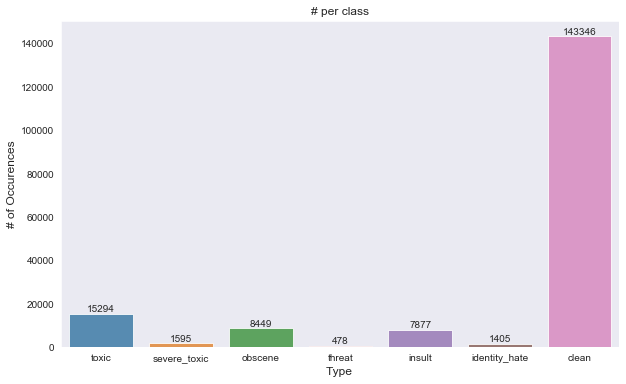

In [14]:
X = train.iloc[:,2:].sum()
# plot
plt.figure(figsize=(10,6))
ax = sns.barplot(X.index, X.values, alpha=0.8)
plt.title("# per class")
plt.ylabel("# of Occurences", fontsize=12)
plt.xlabel("Type ", fontsize=12)
## adding the text labels
rects = ax.patches
labels = X.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+5,label,ha='center',va='bottom')
   
plt.savefig("../insights/plots/counts_of_classes.png")

plt.show()

- The toxicity is not evenly spread out across classes. Hence we might face class imbalance problems.
 
- There are ~95k comments in the training dataset and there are ~21k tags and ~86k clean comments.

- This is only possible when multiple tags are associated with each comment. (eg) a comment can be classified as both toxic and obscene.

### Multi-taging
- Let's check how many comments have multiple tags.

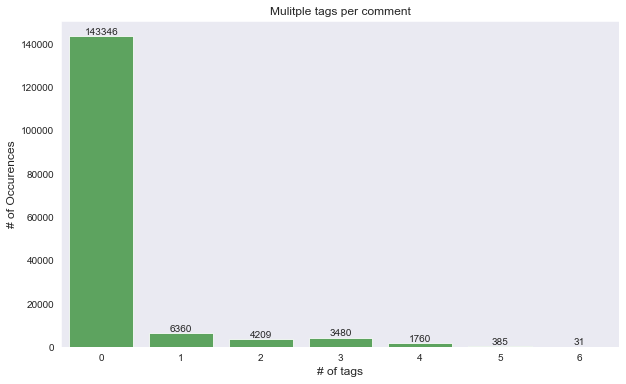

In [15]:
X = rowsums.value_counts()

# plot
plt.figure(figsize=(10,6))
ax = sns.barplot(X.index, X.values, alpha=0.8, color=color[2])
plt.title("Mulitple tags per comment")
plt.ylabel("# of Occurences", fontsize=12)
plt.xlabel("# of tags",fontsize=12)

# adding the text label
rects = ax.patches
labels = X.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x()+rect.get_width()/2,height+5,label,ha='center',va='bottom')

plt.savefig("../insights/plots/mult_tag_comments.png")
plt.show()

- Only ~10% of the total comments have some sort of toxicity in them. There are certain comments(20) thar are marked as all of the above.

### Which tags go together?

Now let's have a look at how often the tags occurs together. A good indicator of that would be correlation plot.

In [16]:
print(train.iloc[:,2:-1])

        toxic  severe_toxic  obscene  threat  insult  identity_hate
0           0             0        0       0       0              0
1           0             0        0       0       0              0
2           0             0        0       0       0              0
3           0             0        0       0       0              0
4           0             0        0       0       0              0
...       ...           ...      ...     ...     ...            ...
159566      0             0        0       0       0              0
159567      0             0        0       0       0              0
159568      0             0        0       0       0              0
159569      0             0        0       0       0              0
159570      0             0        0       0       0              0

[159571 rows x 6 columns]


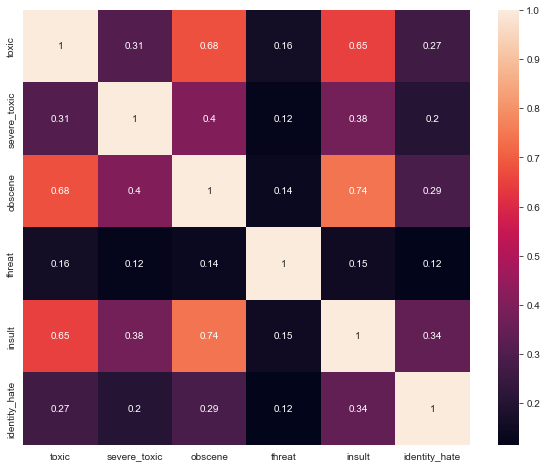

In [17]:
temp_df = train.iloc[:,2:-1]
corr = temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, 
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values,annot=True)
plt.savefig('../insights/plots/correlation.png')

The above plot indicates a pattern of co-occurace but Panda's default Corr
function which uses `Pearson Correlation` does not apply here, since the variables involved and Categorical(binary) variables.

In [18]:
## Crosstab
# Since technically a crosstab between all 6 classes is impossible to visualize, lets take look

## look at toxic with other tags


#Crosstab
# Since technically a crosstab between all 6 classes is impossible to vizualize, lets take a 
# look at toxic with other tags
main_col="toxic"
corr_mats=[]
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

#cell highlighting
# out = out.style.apply(highlight_min,axis=0)
out


severe_toxic       obscene        threat       insult        \
severe_toxic            0     1       0     1       0    1       0     1   
toxic                                                                      
0                  144277     0  143754   523  144248   29  143744   533   
1                   13699  1595    7368  7926   14845  449    7950  7344   

             identity_hate        
severe_toxic             0     1  
toxic                             
0                   144174   103  
1                    13992  1302

The above table represents the Crosstab/confusion matrix of `Toxic Comments` with the other classes.

Some interesting observations:

- A serve toxic comment is always toxic.
- Other classes seem to be a subset of toxic barring a few exceptions

### Example Comments:

In [19]:
print("toxic:")
print(train[train.severe_toxic==1].iloc[3,1])

toxic:
Hi 

Im a fucking bitch.

50.180.208.181


In [20]:
print("severe_toxic:")
print(train[train.severe_toxic==1].iloc[4,1])

severe_toxic:
What a motherfucking piece of crap those fuckheads for blocking us!


In [21]:
print("threat:")
print(train[train.threat==1].iloc[1,1])

threat:
I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndoms


In [22]:
print("obscene:")
print(train[train.obscene==1].iloc[1,1])

obscene:
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!


In [23]:
print("identity_hate:")
print(train[train.identity_hate==1].iloc[4,1])

identity_hate:
u r a tw@ fuck off u gay boy.U r smelly.Fuck ur mum poopie


The was a whole lot of toxicity. Some weird observations:

- Some of the comments are extremely and mere copy paste of the same thing.
- Comments can still contain IP address(eg: 62.158.73.165), usernames(eg: ARKJEDI10) and mystery numbers.

### Wordclouds - Frequent words:

Now, let's look at most frequent word in each category

In [24]:
stopwords = set(STOPWORDS)

##### Clean Comments

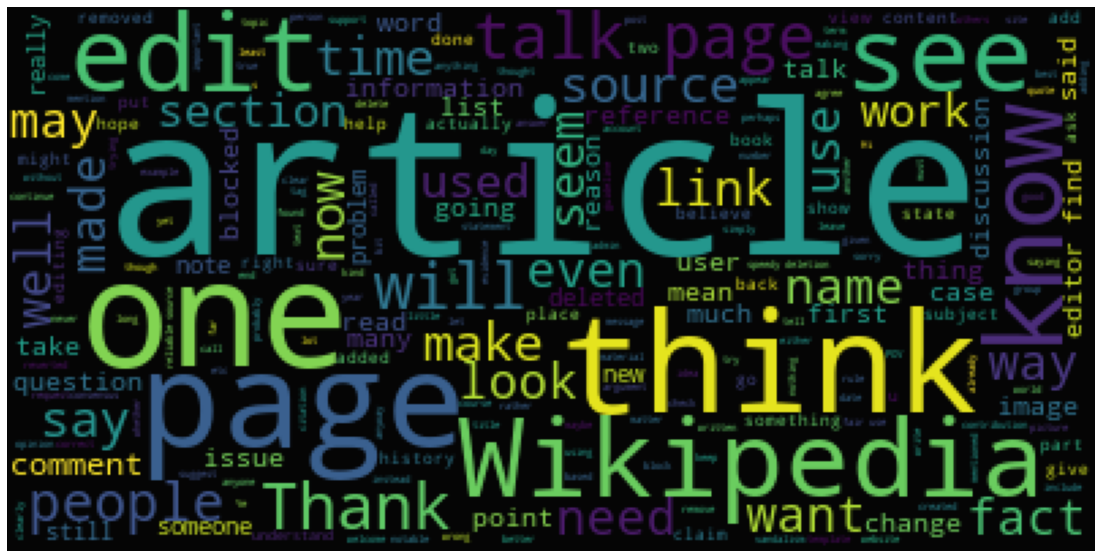

In [37]:
#wordcloud for clean comments
subset_clean=train[train.clean==True]
text=subset_clean.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopwords)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.savefig('../insights/wordclouds/clean_comments_wc.png')
plt.show()

##### Toxic Comments

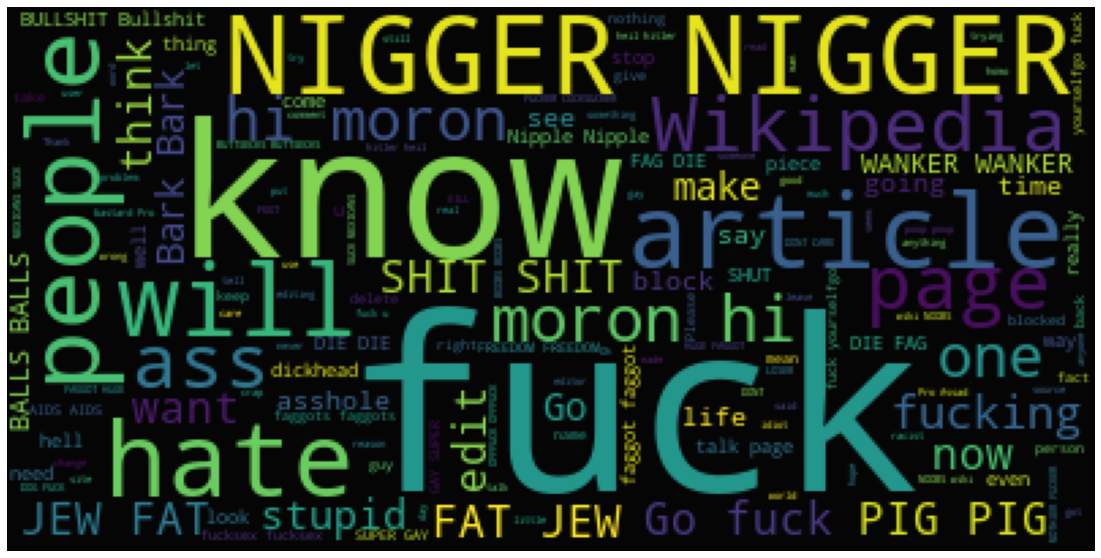

In [38]:
subset_toxic=train[train.toxic==True]
text=subset_toxic.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopwords)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.savefig('../insights/wordclouds/toxic_comments_wc.png')
plt.show()

##### Severe Toxic

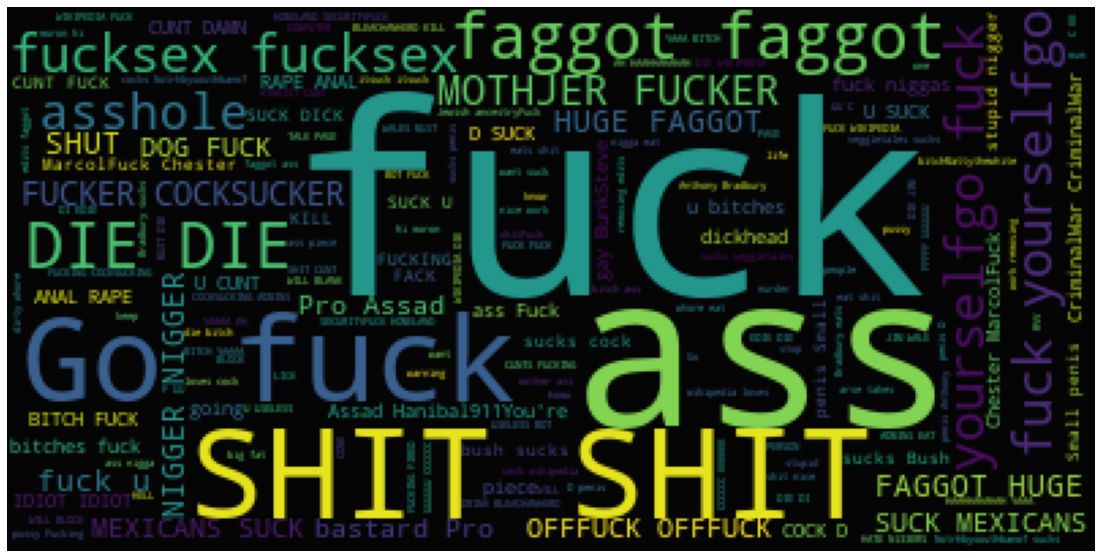

In [39]:
subset_severe_toxic=train[train.severe_toxic==True]
text=subset_severe_toxic.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopwords)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.savefig('../insights/wordclouds/severe_toxic_comments_wc.png')
plt.show()

##### Threat Comments

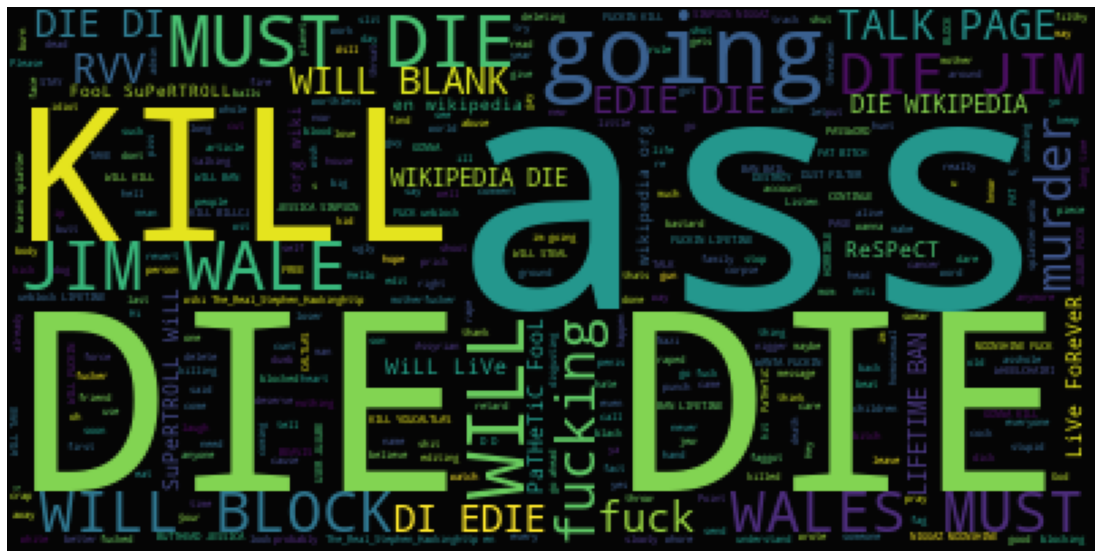

In [40]:
subset_threat=train[train.threat==True]
text=subset_threat.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopwords)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.savefig('../insights/wordclouds/threat_comments_wc.png')
plt.show()

##### Insult Comments

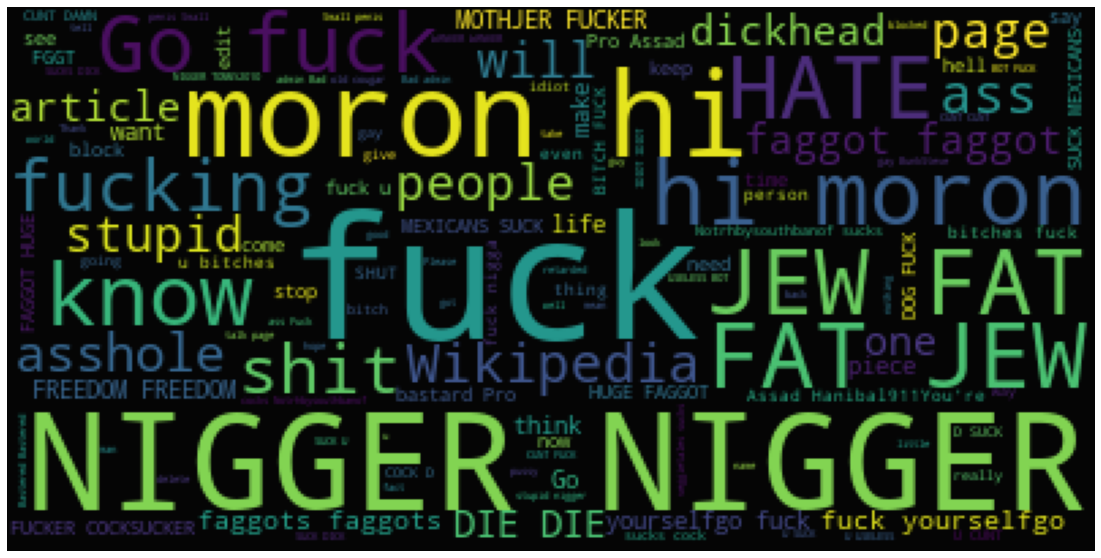

In [41]:
subset_insult=train[train.insult==True]
text=subset_insult.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopwords)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.savefig('../insights/wordclouds/insult_comments_wc.png')
plt.show()